In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# -*- coding: utf-8 -*-
"""
Streamlined Model 4 with optional Optuna hyper‑parameter tuning
==============================================================
• Set **tuning = True** below to run an Optuna search first.
  – After the search the script trains a final model with the *best* params
    for the full number of epochs and proceeds exactly as before.
• Set **tuning = False** to skip the search and use default hyper‑parameters.
"""

# -----------------------------------------------------------------------------
# 0.  User switch ─ set to True to enable hyper‑parameter tuning
# -----------------------------------------------------------------------------
tuning = False # True

# -----------------------------------------------------------------------------
# 1. Imports & basic setup
# -----------------------------------------------------------------------------
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

if tuning:
    import optuna

plt.style.use("ggplot")


# -----------------------------------------------------------------------------
# 2. File locations
# -----------------------------------------------------------------------------
BASE_DIR = "/content/drive/MyDrive/Calibration_ABM"
INCIDENCE_CSV = os.path.join(BASE_DIR, "incidence.csv 1.gz")
THETA_CSV     = os.path.join(BASE_DIR, "theta.csv 1.gz")
OUTPUT_DIR    = os.path.join(BASE_DIR, "model_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)


# -----------------------------------------------------------------------------
# 3. Load & preprocess data (with fixed min/max for incidence)
# -----------------------------------------------------------------------------
print("Loading data …")
incidence_df = pd.read_csv(INCIDENCE_CSV)
theta_df_og  = pd.read_csv(THETA_CSV)


Loading data …


In [14]:
print(incidence_df)
theta_df_og.describe()

       V1  V2  V3   V4   V5   V6   V7   V8   V9  V10  ...  V52  V53  V54  V55  \
0      87  30  37   53   52   77  108  156  190  193  ...    4    5    2    1   
1      98  51  76  105  124  188  268  300  401  406  ...    1    0    0    0   
2      32  27  46   89  126  203  315  466  602  808  ...    0    0    0    0   
3      31  19  20   20   35   32   38   55   71   74  ...    5    3    4    3   
4      74  14  21   30   27   38   52   49   53   70  ...    8   20    6    9   
...    ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59981  10   1   4    1    3    3    4    1    5    7  ...  241  193  185  176   
59982  13   3   4    5    5    6   10   14   18   11  ...   20   13   18   14   
59983  41   6  11    9   13    7    7   12   10   10  ...   66   62   50   68   
59984  83  25  26   40   57   68   82   79   98  120  ...    4    8    2    6   
59985  69  16  17   22   23   30   25   22   33   34  ...  125  127  119  124   

       V56  V57  V58  V59  

,n,preval,crate,recov,R0,ptran
count,59986.000000,59986.000000,59986.000000,59986.000000,59986.000000,59986.000000
mean,7494.356383,0.007643,3.004358,0.125132,3.046553,0.152888
std,1446.069636,0.004028,1.155869,0.046541,1.126062,0.117476
min,5000.000000,0.001001,1.000023,0.071429,1.100004,0.016630
25%,6237.000000,0.004315,2.004890,0.086844,2.070244,0.074184
50%,7495.000000,0.007347,3.001158,0.110622,3.045917,0.118571
75%,8745.750000,0.010389,4.014698,0.153677,4.022083,0.193536
max,9999.000000,0.020000,4.999904,0.249983,4.999887,0.988623


In [15]:
# -*- coding: utf-8 -*-
"""
Streamlined Model 4 with optional Optuna hyper‑parameter tuning
==============================================================
• Set **tuning = True** below to run an Optuna search first.
  – After the search the script trains a final model with the *best* params
    for the full number of epochs and proceeds exactly as before.
• Set **tuning = False** to skip the search and use default hyper‑parameters.
"""

# -----------------------------------------------------------------------------
# 0.  User switch ─ set to True to enable hyper‑parameter tuning
# -----------------------------------------------------------------------------
tuning = False # True

# -----------------------------------------------------------------------------
# 1. Imports & basic setup
# -----------------------------------------------------------------------------
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

if tuning:
    import optuna

plt.style.use("ggplot")


# -----------------------------------------------------------------------------
# 2. File locations
# -----------------------------------------------------------------------------
BASE_DIR = "/content/drive/MyDrive/Calibration_ABM"
INCIDENCE_CSV = os.path.join(BASE_DIR, "incidence.csv 1.gz")
THETA_CSV     = os.path.join(BASE_DIR, "theta.csv 1.gz")
OUTPUT_DIR    = os.path.join(BASE_DIR, "model_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)


# -----------------------------------------------------------------------------
# 3. Load & preprocess data (with fixed min/max for incidence)
# -----------------------------------------------------------------------------
print("Loading data …")
incidence_df = pd.read_csv(INCIDENCE_CSV)
theta_df_og  = pd.read_csv(THETA_CSV)

additional_cols = ["n", "recov"]
additional_raw  = theta_df_og[additional_cols].values
target_cols     = ["ptran", "crate", "R0"]
targets_raw     = theta_df_og[target_cols].values

# Fixed scaling for incidence with min=0, max=5000
INCIDENCE_MIN = 0
INCIDENCE_MAX = 10000

# Initialize the scaler and set fixed parameters
scaler_incidence = MinMaxScaler(feature_range=(0, 1))
scaler_incidence.data_min_ = np.zeros(incidence_df.shape[1])
scaler_incidence.data_max_ = np.ones(incidence_df.shape[1]) * INCIDENCE_MAX
scaler_incidence.data_range_ = scaler_incidence.data_max_ - scaler_incidence.data_min_
scaler_incidence.scale_ = 1.0 / scaler_incidence.data_range_
scaler_incidence.min_ = 0 - scaler_incidence.data_min_ * scaler_incidence.scale_

# Transform using the fixed scaler
X_inc = scaler_incidence.transform(incidence_df)
X_inc = X_inc.reshape(-1, incidence_df.shape[1], 1)  # (N, T, 1)

# Regular scalers for other data
scaler_additional = MinMaxScaler()
scaler_targets    = MinMaxScaler()

add_inputs = scaler_additional.fit_transform(additional_raw)
Y_targets  = scaler_targets.fit_transform(targets_raw)

X_train, X_val, add_train, add_val, y_train, y_val = train_test_split(
    X_inc, add_inputs, Y_targets, test_size=0.2, random_state=42, shuffle=True
)

# PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
add_train_t = torch.tensor(add_train, dtype=torch.float32)
add_val_t   = torch.tensor(add_val,   dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)

BATCH_SIZE = 64
train_ds = torch.utils.data.TensorDataset(X_train_t, add_train_t, y_train_t)
val_ds   = torch.utils.data.TensorDataset(X_val_t,   add_val_t,   y_val_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

Loading data …


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [16]:
X_train_t

tensor([[[0.0089],
         [0.0022],
         [0.0030],
         ...,
         [0.0003],
         [0.0003],
         [0.0006]],

        [[0.0020],
         [0.0005],
         [0.0002],
         ...,
         [0.0018],
         [0.0015],
         [0.0007]],

        [[0.0068],
         [0.0024],
         [0.0008],
         ...,
         [0.0056],
         [0.0056],
         [0.0041]],

        ...,

        [[0.0024],
         [0.0007],
         [0.0008],
         ...,
         [0.0035],
         [0.0027],
         [0.0022]],

        [[0.0052],
         [0.0005],
         [0.0009],
         ...,
         [0.0041],
         [0.0036],
         [0.0028]],

        [[0.0057],
         [0.0011],
         [0.0008],
         ...,
         [0.0036],
         [0.0039],
         [0.0042]]])

In [17]:

# -----------------------------------------------------------------------------
# 4. Model definition
# -----------------------------------------------------------------------------
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int,
                 additional_dim: int, output_dim: int, dropout: float):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(2 * hidden_dim + additional_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid  = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, x, add_inputs):
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = torch.relu(self.fc1(torch.cat((h, add_inputs), dim=1)))
        out = self.fc2(h)
        out = torch.stack([
            self.sigmoid(out[:, 0]),
            self.softplus(out[:, 1]),
            self.softplus(out[:, 2]),
        ], dim=1)
        return out

# -----------------------------------------------------------------------------
# 5. Loss function
# -----------------------------------------------------------------------------

def penalized_loss(y_pred, y_true, add_inputs, lambda_penalty: float):
    mse = nn.functional.mse_loss(y_pred, y_true)
    ptran_p, crate_p, R0_p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    recov = add_inputs[:, 1]
    penalty = nn.functional.mse_loss(R0_p * recov, ptran_p * crate_p)
    return mse + lambda_penalty * penalty

# -----------------------------------------------------------------------------
# 6. Helper: training for a fixed set of hyper‑parameters
# -----------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

def train_eval(params: dict, max_epochs: int, quiet: bool = False):
    model = BiLSTMModel(
        input_dim=1,
        hidden_dim=params["hidden_dim"],
        num_layers=params["num_layers"],
        additional_dim=2,
        output_dim=3,
        dropout=params["dropout"],
    ).to(DEVICE)
    optimiser = optim.Adam(model.parameters(), lr=params["lr"])
    lambda_pen = params["lambda_penalty"]

    for epoch in range(max_epochs):
        model.train()
        for Xb, add_b, yb in train_loader:
            Xb, add_b, yb = Xb.to(DEVICE), add_b.to(DEVICE), yb.to(DEVICE)
            optimiser.zero_grad()
            loss = penalized_loss(model(Xb, add_b), yb, add_b, lambda_pen)
            loss.backward()
            optimiser.step()

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, add_b, yb in val_loader:
            Xb, add_b, yb = Xb.to(DEVICE), add_b.to(DEVICE), yb.to(DEVICE)
            val_loss += penalized_loss(model(Xb, add_b), yb, add_b, lambda_pen).item() * Xb.size(0)
    val_loss /= len(val_loader.dataset)

    if not quiet:
        print(f"Validation loss: {val_loss:.4f}")
    return val_loss, model

# -----------------------------------------------------------------------------
# 7. Optuna tuning (optional)
# -----------------------------------------------------------------------------
DEFAULT_PARAMS = {
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.3,
    "lr": 1e-3,
    "lambda_penalty": 0.03,
}
OPTUNA_OPTIMAL_PARAMS = {
    'hidden_dim': 160,
    'num_layers': 3,
    'dropout': 0.5,
    'lr': 0.0002766923888203664,
    'lambda_penalty': 0.0001773491932427762}

if tuning:
    print("\n⚙️  Hyper‑parameter tuning with Optuna …")

    def objective(trial):
        params = {
            "hidden_dim": trial.suggest_int("hidden_dim", 64, 256, step=32),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "dropout": trial.suggest_float("dropout", 0.1, 0.5, step=0.05),
            "lr": trial.suggest_float("lr", 1e-4, 3e-3, log=True),
            "lambda_penalty": trial.suggest_float("lambda_penalty", 0.0, 0.3, log=False)
        }
        val_loss, _ = train_eval(params, max_epochs=30, quiet=True)
        return val_loss

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40, timeout=60 * 30)
    print("Best params:", study.best_trial.params)
    BEST_PARAMS = study.best_trial.params
else:
    #BEST_PARAMS = DEFAULT_PARAMS
    BEST_PARAMS = OPTUNA_OPTIMAL_PARAMS


In [18]:
print("\nTraining final model …")
FINAL_EPOCHS = 100
_, final_model = train_eval(BEST_PARAMS, FINAL_EPOCHS)


Training final model …
Validation loss: 0.0296


Evaluating final model …

Mean Absolute Error (original units):
  ptran: 0.0577
  crate: 0.9892
  R0   : 0.0572


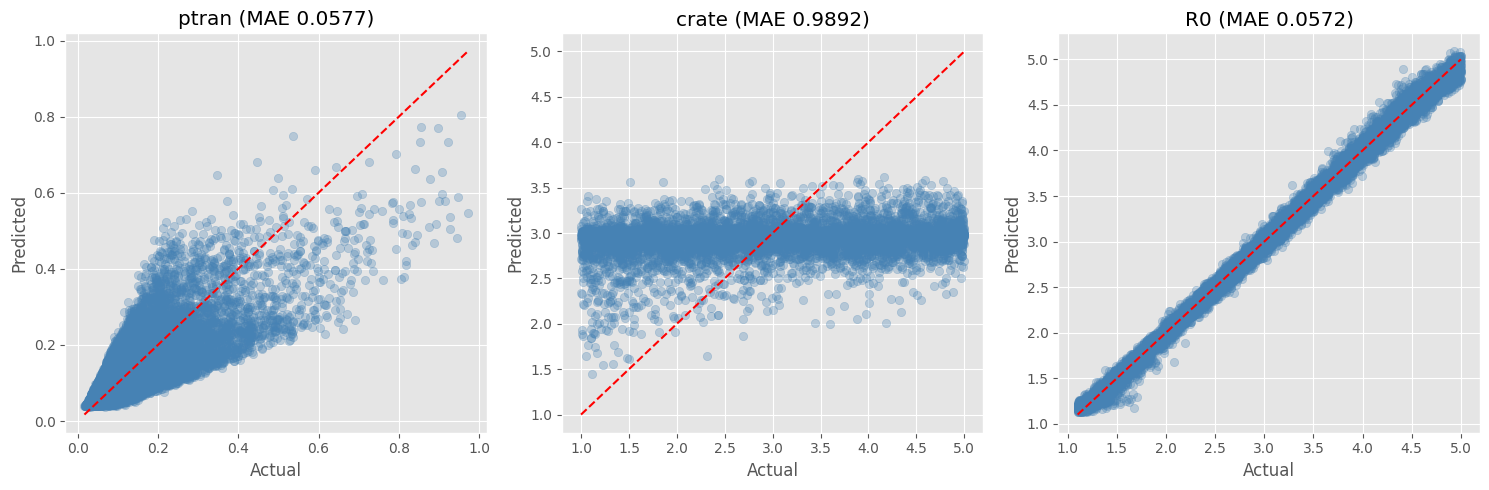

In [19]:


# -----------------------------------------------------------------------------
# 9. Evaluation in original units + plots
# -----------------------------------------------------------------------------
print("Evaluating final model …")
final_model.eval()
with torch.no_grad():
    preds, trues = [], []
    for Xb, add_b, yb in val_loader:
        preds.append(final_model(Xb.to(DEVICE), add_b.to(DEVICE)).cpu().numpy())
        trues.append(yb.cpu().numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

preds_orig = scaler_targets.inverse_transform(preds)
trues_orig = scaler_targets.inverse_transform(trues)
mae_vals = [mean_absolute_error(trues_orig[:, i], preds_orig[:, i]) for i in range(3)]
print("\nMean Absolute Error (original units):")
for col, mae in zip(target_cols, mae_vals):
    print(f"  {col:5s}: {mae:.4f}")

plt.figure(figsize=(15, 5))
for i, col in enumerate(target_cols):
    ax = plt.subplot(1, 3, i + 1)
    ax.scatter(trues_orig[:, i], preds_orig[:, i], color="steelblue", alpha=0.3)
    lims = [trues_orig[:, i].min(), trues_orig[:, i].max()]
    ax.plot(lims, lims, "r--")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{col} (MAE {mae_vals[i]:.4f})")
plt.tight_layout()
plt.show()



In [23]:
# -----------------------------------------------------------------------------
# 10. Persist model & scalers (with fixed incidence scaling parameters)
# -----------------------------------------------------------------------------
print("Saving final model & scalers …")
torch.save(final_model.state_dict(), os.path.join(OUTPUT_DIR, "model4_bilstm.pt"))
joblib.dump(scaler_additional, os.path.join(OUTPUT_DIR, "scaler_additional.pkl"))
joblib.dump(scaler_targets, os.path.join(OUTPUT_DIR, "scaler_targets.pkl"))
joblib.dump(scaler_incidence, os.path.join(OUTPUT_DIR, "scaler_incidence.pkl"))

# Also save the fixed scaling parameters separately for easier reference
incidence_scaling_params = {
    'min': INCIDENCE_MIN,
    'max': INCIDENCE_MAX
}
joblib.dump(incidence_scaling_params, os.path.join(OUTPUT_DIR, "incidence_scaling_params.pkl"))

print("Done →", OUTPUT_DIR)

Saving final model & scalers …
Done → /content/drive/MyDrive/Calibration_ABM/model_output


In [24]:
# 📦 Import required packages
import os
import torch
import torch.nn as nn
import numpy as np
import joblib

# 📁 Define file paths
OUTPUT_DIR = "/content/drive/MyDrive/Calibration_ABM/model_output"

# Load scalers
scaler_incidence = joblib.load(os.path.join(OUTPUT_DIR, "scaler_incidence.pkl"))
scaler_additional = joblib.load(os.path.join(OUTPUT_DIR, "scaler_additional.pkl"))
scaler_targets = joblib.load(os.path.join(OUTPUT_DIR, "scaler_targets.pkl"))

# 🧠 Define the BiLSTM model class
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int,
                 additional_dim: int, output_dim: int, dropout: float):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(2 * hidden_dim + additional_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.sigmoid  = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, x, add_inputs):
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)
        h = torch.relu(self.fc1(torch.cat((h, add_inputs), dim=1)))
        out = self.fc2(h)
        out = torch.stack([
            self.sigmoid(out[:, 0]),
            self.softplus(out[:, 1]),
            self.softplus(out[:, 2]),
        ], dim=1)
        return out

# 🧠 Load the model and its weights
model = BiLSTMModel(input_dim=1, hidden_dim=160, num_layers=3,
                    additional_dim=2, output_dim=3, dropout=0.5)
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "model4_bilstm.pt"), map_location="cpu"))
model.eval()

# 🔢 Incidence vector (length = 60)
incidence_vec = np.array([
    103, 37, 60, 74, 108, 125, 138, 186, 215, 276, 318, 331, 414, 402, 446, 454, 405, 401, 373, 334, 285,
    241, 219, 156, 140, 108, 93, 82, 73, 78, 48, 38, 34, 22, 27, 22, 20, 11, 14, 8, 11, 14,
    8, 6, 6, 2, 0, 7, 2, 4, 4, 1, 1, 2, 2, 1, 0, 2, 1, 1, 0
])


# ✅ Preprocess input
X_input_scaled = scaler_incidence.transform(incidence_vec.reshape(1, -1))
X_input_scaled = X_input_scaled.reshape(1, 61, 1)
X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)

# Additional inputs
n = 7087
recov =   0.203
add_input = np.array([[n, recov]])
add_input_scaled = scaler_additional.transform(add_input)
add_input_tensor = torch.tensor(add_input_scaled, dtype=torch.float32)

# 🔮 Make prediction
with torch.no_grad():
    pred_scaled = model(X_input_tensor, add_input_tensor).numpy()
    pred = scaler_targets.inverse_transform(pred_scaled)

# 📢 Display result
ptran, crate, R0 = pred[0]
print(f"Predicted Transmission Rate (ptran): {ptran:.4f}")
print(f"Predicted Contact Rate (crate):      {crate:.4f}")
print(f"Predicted R0:                        {R0:.4f}")


Predicted Transmission Rate (ptran): 0.2208
Predicted Contact Rate (crate):      2.8795
Predicted R0:                        2.5652
